<a href="https://colab.research.google.com/github/hrtnisri2016/celestial-bodies-database/blob/main/fcc_cat_dog_without_long_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog Image Classifier

For this challenge, I will complete the code to classify images of dogs and cats. I'll use TensorFlow 2.0 and Keras to build a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. The structure of the dataset files that are used in this notebook looks like this:

```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

Import required libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

Before being fed into the network, images must be formatted into properly pre-processed floating-point tensors. The steps involved in preparing these images are: 

1.   Read images from the disk. 
2.   Decode the contents of these images and convert them into a proper grid format according to their RGB content. 
3.   Convert them into floating-point tensors. 
4.   Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values. 

Fortunately, the class `tf.keras.preprocessing.image.ImageDataGenerator` can be utilized to complete all of these tasks. This can be done with just a few lines of code.

In [ ]:
# Create image generators
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

After defining our generators for training, validation, and test images, the `flow_from_directory` method will load images from the disk, implement rescaling, and resize them using a single line of code.

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=batch_size,
    shuffle=False,
    class_mode=None,
    classes=['.'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


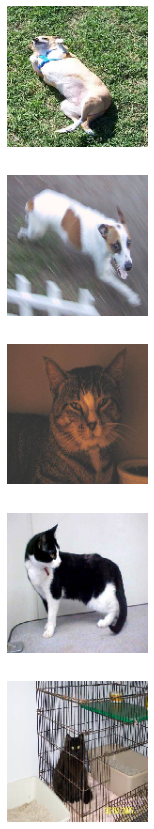

In [ ]:
# The plotImages function will be used a few times to plot images
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

# Plot five random training images
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

Overfitting is possible due to the small number of training examples. One solution is to generate more training data from existing examples using random transformations.

In [ ]:
# Recreate the train_image_generator using ImageDataGenerator
train_image_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255)

`train_data_gen` is created just like before, but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


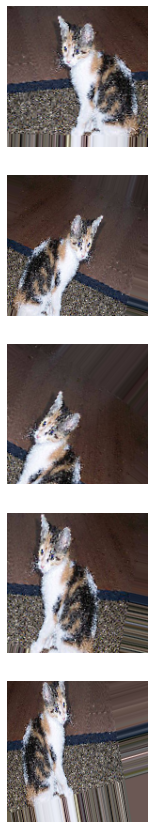

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In the cell below, I create a model for the neural network that outputs class probabilities. It utilizes the Keras sequential model. It also involves a stack of Conv2D, MaxPooling2D, and Dropout layers and then a fully connected layer on top that is activated by a ReLU activation function.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Compile the model, passing the arguments to set the optimizer and loss. Also, pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Use the `fit` method on the `model` to train the network.

In [ ]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=30,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(batch_size)))
)

Visualize the accuracy and loss of the model.

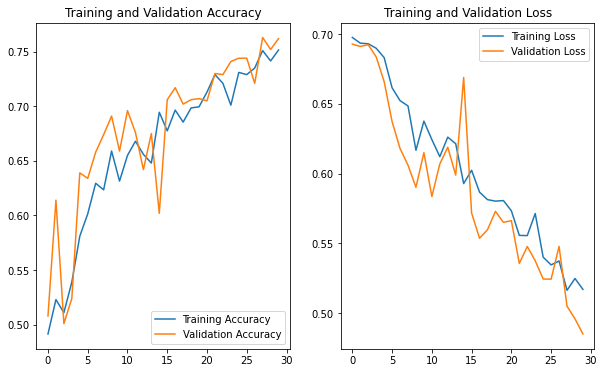

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now it is time to use the model to predict whether a new image is a cat or a dog. From this, the probability that each test image (from `test_data_gen`) is a dog or a cat can be obtained, and `probabilities` would be a list of integers.

In [ ]:
probabilities = model.predict(test_data_gen)[:, 0]

1/1 [==============================] - 1s 589ms/step


Pass the test images and the probabilities corresponding to each test image to the `plotImages` function.

In [ ]:
test_images = next(test_data_gen)
plotImages(test_images, probabilities=probabilities)

Finally, the accuracy of the model will be shown in the last cell below.

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!
